Using device: cuda
Epoch [1/20], Loss: 0.2592, Test Accuracy: 96.33%
Epoch [2/20], Loss: 0.1237, Test Accuracy: 97.33%
Epoch [3/20], Loss: 0.1000, Test Accuracy: 97.26%
Epoch [4/20], Loss: 0.0794, Test Accuracy: 97.76%
Epoch [5/20], Loss: 0.0748, Test Accuracy: 97.53%
Epoch [6/20], Loss: 0.0648, Test Accuracy: 97.81%
Epoch [7/20], Loss: 0.0580, Test Accuracy: 97.36%
Epoch [8/20], Loss: 0.0553, Test Accuracy: 97.69%
Epoch [9/20], Loss: 0.0502, Test Accuracy: 97.99%
Epoch [10/20], Loss: 0.0495, Test Accuracy: 97.96%
Epoch [11/20], Loss: 0.0266, Test Accuracy: 98.46%
Epoch [12/20], Loss: 0.0177, Test Accuracy: 98.52%
Epoch [13/20], Loss: 0.0160, Test Accuracy: 98.48%
Epoch [14/20], Loss: 0.0150, Test Accuracy: 98.48%
Epoch [15/20], Loss: 0.0126, Test Accuracy: 98.44%
Epoch [16/20], Loss: 0.0124, Test Accuracy: 98.43%
Epoch [17/20], Loss: 0.0121, Test Accuracy: 98.55%
Epoch [18/20], Loss: 0.0113, Test Accuracy: 98.54%
Epoch [19/20], Loss: 0.0095, Test Accuracy: 98.55%
Epoch [20/20], Loss: 

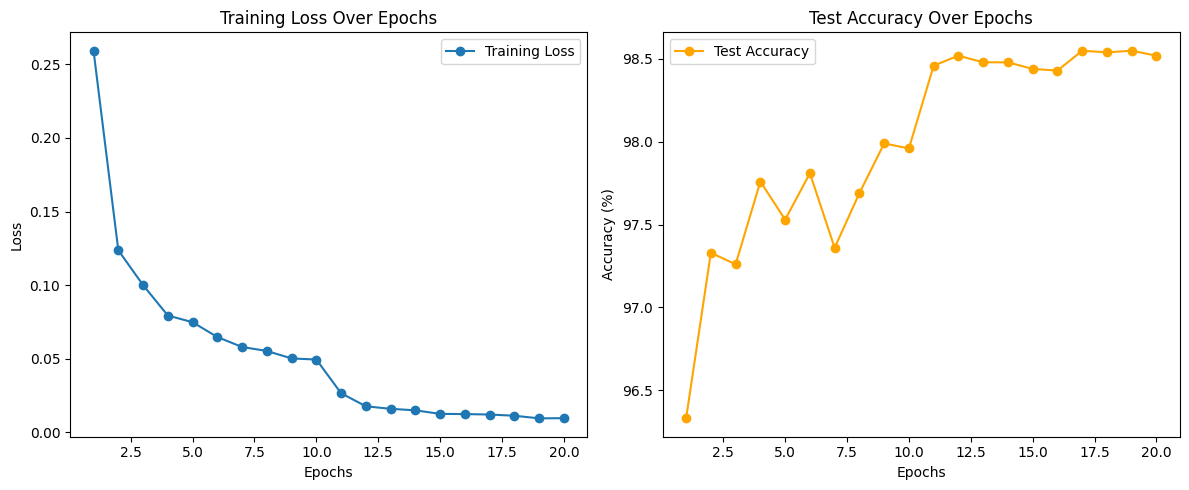

Model saved as mnist_model.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Check GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load and normalize the MNIST dataset (Standard Normalization)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # Must match with inference time
])

# Download the training and test datasets
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)  # Reduced batch size

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

# Define a better neural network with weight initialization
class ImprovedNN(nn.Module):
    def __init__(self):
        super(ImprovedNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)  # Added dropout to reduce overfitting

        # Initialize weights using Kaiming Normal
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten input
        x = self.relu(self.fc1(x))
        x = self.dropout(x)  # Apply dropout
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x  # Raw logits (Softmax will be applied in loss function)

# Initialize the model, loss function, and optimizer
model = ImprovedNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # L2 Regularization

# Training loop with Learning Rate Scheduling
num_epochs = 20
train_losses = []
test_accuracies = []
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)  # Reduce LR after 10 epochs

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(trainloader)
    train_losses.append(avg_loss)

    # Evaluate model
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)
    scheduler.step()  # Adjust learning rate

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.2f}%")

# Plot results
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, 'o-', label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), test_accuracies, 'o-', label='Test Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

# Save model
model_path = "mnist_model.pth"
torch.save(model.state_dict(), model_path)
print(f"Model saved as {model_path}")

# Download the model to your local system
from google.colab import files
files.download(model_path)
